In [142]:
import pandas as pd
import xgboost as xgb
import random
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import pickle as pkl

from typing import List
from sklearn.impute import SimpleImputer
from sklearn import preprocessing, model_selection
from sklearn import metrics

module_path = os.path.abspath(os.path.join('../CATENets/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import catenets.models.torch.pseudo_outcome_nets as pseudo_outcome_nets

In [300]:

def normalize_data(x_train):
    
    x_normalized_train = (x_train - np.min(x_train, axis=0)) / (np.max(x_train, axis=0) - np.min(x_train, axis=0))

    return x_normalized_train


def subgroup_ate(
    method: str,
    features: List[int],
    x_train: np.ndarray,
    x_test: np.ndarray,
    y_train: np.ndarray,
    y_test: np.ndarray,
    estimated_ate_test: np.ndarray,
) -> List[np.ndarray]:

    
    xgb_model = xgb.XGBClassifier(  
        # max_depth=3,
        # reg_lambda=2,
        # min_split_loss=2
    )

    xgb_model.fit(x_train[:, features], y_train)
    y_pred = xgb_model.predict(x_test[:, features])
    
    auroc = metrics.roc_auc_score(y_test, y_pred)

    
    ate = np.sum(estimated_ate_test[y_pred == 1])/len(estimated_ate_test)
    
    print("===================")
    print("%s - auroc %s"%(method, auroc))
    print("%s - ATE %s"%(method, ate))

    
    return auroc, ate

def feature_idx(
    dataset: np.ndarray,
    method: str,
    cohort: str,
    learner: str,
    shuffle: str,
    features: List[str]=None
)-> List[int]:
    
    if method == "shap":
        file_path = f"../results/{cohort}/naive_shap_top_5_features_shuffle_{shuffle}_{learner}.csv"
    elif method == "ig":
        file_path = f"../results/{cohort}/integrated_gradients_top_5_features_shuffle_{shuffle}_{learner}.csv"
    elif method == "baseline_shap":
        file_path = f"../results/{cohort}/baseline_shapley_value_sampling_top_5_features_shuffle_{shuffle}_{learner}.csv"
    elif method == "marginal_shap":
        file_path = f"../results/{cohort}/marginal_shapley_value_sampling_top_5_features_shuffle_{shuffle}_{learner}.csv"
    
    
    df = pd.read_csv(file_path,keep_default_na=False)
    
    df_sorted = df.sort_values(
        by='count (%)', 
        ascending=False
    )
    
    
    outcome_col = "aliveind6"
    treatment_col = "itt_treat"
    
    print(df_sorted["feature"].head(5).tolist())
    
    columns = x.drop([treatment_col, outcome_col], axis=1).columns
    
    if features != None:
        indices  = [ columns.get_loc(col) for col in features ]

    else:
        indices  = [ columns.get_loc(col) for col in df_sorted["feature"].head(5) ]
    
    
    return indices

In [301]:


def gen_data(random_state=0):
    
    ist3 = pd.read_sas("../data/datashare_aug2015.sas7bdat")
    
    outcome_col = "aliveind6"
    treatment_col = "itt_treat"
    
    continuous_vars = [
        "age",
        "weight",
        "glucose",
        # "gcs_eye_rand",
        # "gcs_motor_rand",
        # "gcs_verbal_rand",
        "gcs_score_rand",
        "nihss" ,
        "sbprand",
        "dbprand"
    ]

    cate_variables = [
        "infarct",
        "stroketype"
    ]

    binary_vars = [
        "gender",
        "antiplat_rand",
        "atrialfib_rand"
    ]

    x = ist3[continuous_vars + cate_variables + binary_vars + [treatment_col] + [outcome_col]]

    x["antiplat_rand"] = np.where(x["antiplat_rand"]== 1, 1, 0)
    x["atrialfib_rand"] = np.where(x["atrialfib_rand"]== 1, 1, 0)
    x["gender"] = np.where(x["gender"]== 2, 1, 0)
    
    x[treatment_col] = np.where(x[treatment_col]== 0, 1, 0)
    x[outcome_col] = np.where(x[outcome_col]== 1, 1, 0)
    x[continuous_vars] = normalize_data(x[continuous_vars])
    
    x = pd.get_dummies(x, columns=cate_variables)
    n, feature_size = x.shape
    names = x.drop([treatment_col, outcome_col], axis=1).columns

    ## impute missing value

    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp.fit(x)
    x_train_scaled = imp.transform(x)
    
    treatment_index = x.columns.get_loc(treatment_col)
    outcome_index = x.columns.get_loc(outcome_col)
    
    var_index = [i for i in range(feature_size) if i not in [treatment_index, outcome_index]]

    x_train, x_test, y_train, y_test = model_selection.train_test_split(
                                                 x_train_scaled,  
                                                 ist3["aliveind6"], 
                                                 test_size=0.2, 
                                                 random_state=random_state,
                                        )

    x_train, x_val, y_train, y_val = model_selection.train_test_split(
                                                x_train,
                                                y_train,
                                                test_size=0.2,
                                                random_state=random_state,
                                        )

    x_train = x_train[:, var_index]
    x_test = x_test[:, var_index]

    w_train = x_train[:, treatment_index]
    w_test =  x_test[:, treatment_index]

    return x, x_train, x_test, w_train, w_test, y_train, y_test

In [302]:
learner = "TLearner"
dataset = "ist3"
shuffle = True
seeds = [0,1,2,3,4]

results_train = pkl.load(open(f'../results/ist3/train_shuffle_{shuffle}_{learner}.pkl', "rb"))
results_test = pkl.load(open(f"../results/ist3/test_shuffle_{shuffle}_{learner}.pkl", "rb"))

# print(np.mean(results_train), np.std(results_train)/np.sqrt(results_train.shape[1]))
# print(np.mean(results_test), np.std(results_test)/np.sqrt(results_test.shape[1]))


for i , seed in enumerate(seeds):

    x, x_train, x_test, w_train, w_test, y_train, y_test = gen_data(seed)
    
    threshold = np.mean(results_train, axis=1)[i]
    
    print(' ATE thresold: %s for seed %s;'%(threshold, seed) )
    
    y_true_train = (results_train[i] > threshold)
    y_true_test = (results_test[i] > threshold)
        
    explainers = {
        # "shap": feature_idx(x, "shap","ist3", learner, shuffle),
        "baseline_shap ": feature_idx(x, "baseline_shap",dataset, learner, shuffle ), 
        "marginal_shap": feature_idx(x, "marginal_shap",dataset, learner, shuffle),
        "ig": feature_idx(x, "ig", dataset,learner, shuffle), 
        "new": feature_idx(
            x, 
            "ig",
            dataset,
            learner,
            shuffle,
            [ 
                'gcs_score_rand',
                'antiplat_rand', 
                'stroketype_1.0', 
                'stroketype_2.0', 
                'stroketype_3.0', 
                'stroketype_4.0', 
                'stroketype_5.0', 
                'infarct_1.0',
                'infarct_2.0', 
                'age'
            ] 
        ),
        "full features": [ i for i in range(x_train.shape[1])],
        "random features": np.random.randint(x_train.shape[1], size=(5)),
    }
    
    for explainer, features in explainers.items():
        
        subgroup_ate(
            explainer,
            features,
            x_train, 
            x_test,
            y_true_train,
            y_true_test,
            results_test[i],
        )


    print("===================")
    print("original", np.sum(results_test[i][w_test==1])/results_test.shape[1])


/tmp/ipykernel_646435/2352866197.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["antiplat_rand"] = np.where(x["antiplat_rand"]== 1, 1, 0)
/tmp/ipykernel_646435/2352866197.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["atrialfib_rand"] = np.where(x["atrialfib_rand"]== 1, 1, 0)
/tmp/ipykernel_646435/2352866197.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

 ATE thresold: 0.034244496295713925 for seed 0;
['nihss', 'stroketype_1.0', 'infarct_1.0', 'antiplat_rand', 'gender']
['weight', 'nihss', 'gender', 'dbprand', 'stroketype_5.0']
['nihss', 'gcs_score_rand', 'age', 'weight', 'infarct_0.0']
['nihss', 'gcs_score_rand', 'age', 'weight', 'infarct_0.0']
baseline_shap  - auroc 0.4880280923344948
baseline_shap  - ATE 0.019244789669084588
marginal_shap - auroc 0.4808090156794425
marginal_shap - ATE 0.013262548123346719
ig - auroc 0.5244337979094077
ig - ATE 0.01971342096402873
new - auroc 0.4965592334494774
new - ATE 0.013306757094587094
full features - auroc 0.5311683362369338
full features - ATE 0.02216082568628686
random features - auroc 0.4845982142857143
random features - ATE 0.013740289186110607
original 0.02030844463547922


/tmp/ipykernel_646435/2352866197.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["antiplat_rand"] = np.where(x["antiplat_rand"]== 1, 1, 0)
/tmp/ipykernel_646435/2352866197.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["atrialfib_rand"] = np.where(x["atrialfib_rand"]== 1, 1, 0)
/tmp/ipykernel_646435/2352866197.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

 ATE thresold: 0.020059162496668732 for seed 1;
['nihss', 'stroketype_1.0', 'infarct_1.0', 'antiplat_rand', 'gender']
['weight', 'nihss', 'gender', 'dbprand', 'stroketype_5.0']
['nihss', 'gcs_score_rand', 'age', 'weight', 'infarct_0.0']
['nihss', 'gcs_score_rand', 'age', 'weight', 'infarct_0.0']
baseline_shap  - auroc 0.4991806163524779
baseline_shap  - ATE 0.011340917147929232
marginal_shap - auroc 0.4780526165284529
marginal_shap - ATE 0.008018985298604902
ig - auroc 0.47437363894327006
ig - ATE 0.011081637504711575
new - auroc 0.49398385429269054
new - ATE 0.009915859068711664
full features - auroc 0.48738479135962687
full features - ATE 0.012811212759016963
random features - auroc 0.49193264556432986
random features - ATE 0.010540445975014169
original 0.010872185776467378


/tmp/ipykernel_646435/2352866197.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["antiplat_rand"] = np.where(x["antiplat_rand"]== 1, 1, 0)
/tmp/ipykernel_646435/2352866197.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["atrialfib_rand"] = np.where(x["atrialfib_rand"]== 1, 1, 0)
/tmp/ipykernel_646435/2352866197.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

 ATE thresold: 0.0018469869733685445 for seed 2;
['nihss', 'stroketype_1.0', 'infarct_1.0', 'antiplat_rand', 'gender']
['weight', 'nihss', 'gender', 'dbprand', 'stroketype_5.0']
['nihss', 'gcs_score_rand', 'age', 'weight', 'infarct_0.0']
['nihss', 'gcs_score_rand', 'age', 'weight', 'infarct_0.0']
baseline_shap  - auroc 0.5389457511716332
baseline_shap  - ATE 0.0045990136542543155
marginal_shap - auroc 0.49512003713856223
marginal_shap - ATE 0.0009293968680343872
ig - auroc 0.48752100097267664
ig - ATE -0.0008150581132368947
new - auroc 0.49813754531788845
new - ATE -0.0006720341198895083
full features - auroc 0.49814307188964535
full features - ATE 0.0030215623952706133
random features - auroc 0.5049573348660359
random features - ATE -0.0005127600589045976
original 0.0006489926086864519


/tmp/ipykernel_646435/2352866197.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["antiplat_rand"] = np.where(x["antiplat_rand"]== 1, 1, 0)
/tmp/ipykernel_646435/2352866197.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["atrialfib_rand"] = np.where(x["atrialfib_rand"]== 1, 1, 0)
/tmp/ipykernel_646435/2352866197.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

 ATE thresold: 0.008443488283360993 for seed 3;
['nihss', 'stroketype_1.0', 'infarct_1.0', 'antiplat_rand', 'gender']
['weight', 'nihss', 'gender', 'dbprand', 'stroketype_5.0']
['nihss', 'gcs_score_rand', 'age', 'weight', 'infarct_0.0']
['nihss', 'gcs_score_rand', 'age', 'weight', 'infarct_0.0']
baseline_shap  - auroc 0.4784684158504807
baseline_shap  - ATE 0.006284922109748033
marginal_shap - auroc 0.506441504178273
marginal_shap - ATE 0.009972930657240076
ig - auroc 0.5090416928744721
ig - ATE 0.007811003933849405
new - auroc 0.5439392577949501
new - ATE 0.011179773744557796
full features - auroc 0.560983691257076
full features - ATE 0.015089459975036797
random features - auroc 0.5124898912750472
random features - ATE 0.011761884332390555
original 0.009177680107376721


/tmp/ipykernel_646435/2352866197.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["antiplat_rand"] = np.where(x["antiplat_rand"]== 1, 1, 0)
/tmp/ipykernel_646435/2352866197.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["atrialfib_rand"] = np.where(x["atrialfib_rand"]== 1, 1, 0)
/tmp/ipykernel_646435/2352866197.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

 ATE thresold: 0.015189657946923858 for seed 4;
['nihss', 'stroketype_1.0', 'infarct_1.0', 'antiplat_rand', 'gender']
['weight', 'nihss', 'gender', 'dbprand', 'stroketype_5.0']
['nihss', 'gcs_score_rand', 'age', 'weight', 'infarct_0.0']
['nihss', 'gcs_score_rand', 'age', 'weight', 'infarct_0.0']
baseline_shap  - auroc 0.4986916395222584
baseline_shap  - ATE 0.008582553441162164
marginal_shap - auroc 0.49566232356134643
marginal_shap - ATE 0.005623307435035313
ig - auroc 0.5329315960912052
ig - ATE 0.013353053722806778
new - auroc 0.5016829533116178
new - ATE 0.010324051761708208
full features - auroc 0.49388165038002174
full features - ATE 0.007643040036399046
random features - auroc 0.5201302931596091
random features - ATE 0.008495973176100404
original 0.010272341597782328


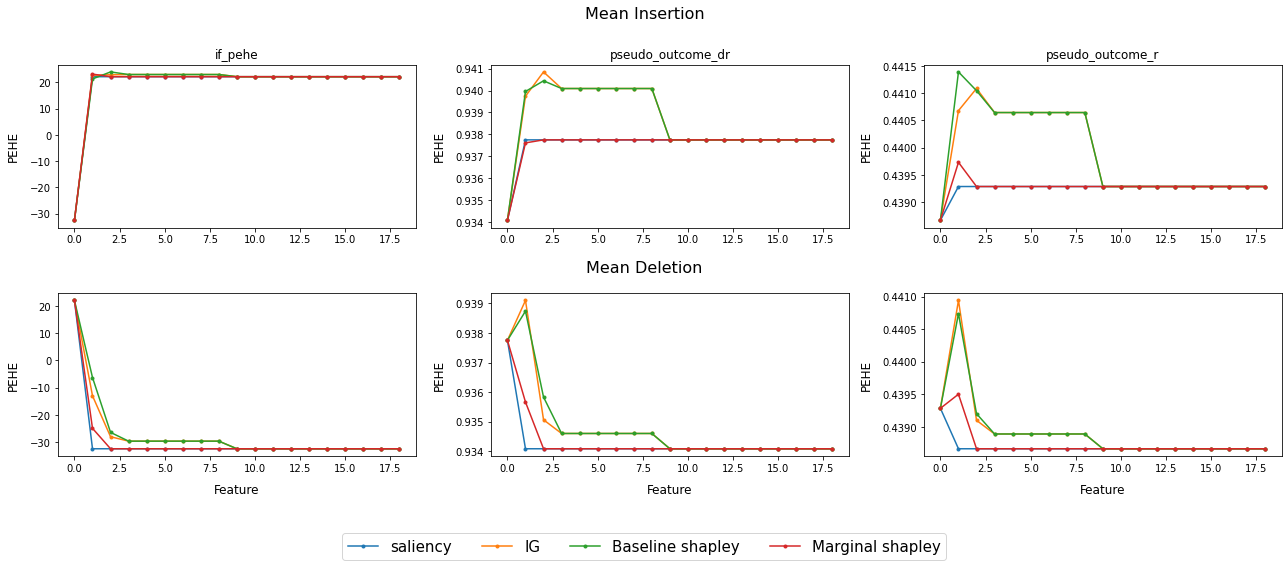

In [359]:
learner = "XLearner"
shuffle = "True"

explainers = [
    "saliency",
    "integrated_gradients", 
    "baseline_shapley_value_sampling",
    "marginal_shapley_value_sampling"
    # "naive_shap"
]

selection_types = [ 
    "if_pehe",
    "pseudo_outcome_dr", 
    "pseudo_outcome_r"
]

# Initialize dictionaries to store all results
insertion_results_all = {exp: {sel: [] for sel in selection_types} for exp in explainers}
deletion_results_all = {exp: {sel: [] for sel in selection_types} for exp in explainers}

auroc_all = {exp: [] for exp in explainers}


# Loop over the different files

seeds = [0, 1, 2,3, 4]

for i, file_num in enumerate(seeds):  # assuming there are 5 files, from 0 to 4
    
    # if file_num not in [1]:

    for selection_type in selection_types:
        file_path = f"../results/ist3/insertion_deletion_shuffle_{shuffle}_{learner}_seed_{file_num}.pkl"
        results = pkl.load(open(file_path,'rb'))

        for exp_index, exp in enumerate(explainers):
            insertion_results_all[exp][selection_type].append((results[exp_index][2][selection_type]))
            deletion_results_all[exp][selection_type].append((results[exp_index][3][selection_type]))
            auroc_all[exp].append(results[exp_index][5])


# Create a grid for subplots
gs = gridspec.GridSpec(2, len(selection_types))

# Create figure
fig = plt.figure(figsize=(6 * len(selection_types), 8))

# To keep track of labels and lines for the legend
handles, labels = [], []

# Calculate and plot mean results
for i, selection_type in enumerate(selection_types):
    for exp in explainers:
        if exp == "baseline_shapley_value_sampling":
            label = "Baseline shapley"
        elif exp == "marginal_shapley_value_sampling":
            label = "Marginal shapley"
        elif exp == "integrated_gradients":
            label = "IG"
        else:
            label = exp
        
        insertion_results_mean = np.mean(insertion_results_all[exp][selection_type], axis=0)
        deletion_results_mean = np.mean(deletion_results_all[exp][selection_type], axis=0)
        features_num = len(insertion_results_mean)

        
        insertion_results_std = np.std(insertion_results_all[exp][selection_type], axis=0)/np.sqrt(len(seeds))
        deletion_results_std = np.std(deletion_results_all[exp][selection_type], axis=0)/np.sqrt(len(seeds))

        # Insertion subplot
        ax1 = plt.subplot(gs[0, i])
        ax1.set_title(f"{selection_type}")
        ax1.set_ylabel('PEHE', fontsize=12, labelpad=10)
        
        # Plot and store the line and label for legend
        line, = ax1.plot(range(features_num), insertion_results_mean, '-o', markersize=3)
        # ax1.fill_between(range(features_num), insertion_results_mean - insertion_results_std, insertion_results_mean + insertion_results_std, alpha=0.2)

        # Deletion subplot
        ax2 = plt.subplot(gs[1, i])
        ax2.set_ylabel('PEHE', fontsize=12, labelpad=10)
        ax2.plot(range(features_num), deletion_results_mean, '-o', markersize=3)
        # ax2.fill_between(range(features_num), deletion_results_mean - deletion_results_std, deletion_results_mean + deletion_results_std, alpha=0.2)

        # Add the line handle and label only if it doesn't exist
        if label not in labels:
            handles.append(line)
            labels.append(label)

# Set the x-label for only the bottom subplots
for i in range(len(selection_types)):
    ax = plt.subplot(gs[1, i])
    ax.set_xlabel('Feature', fontsize=12, labelpad=10)

# Set main titles for each row, outside of loops, and adjust positions
fig.text(0.5, 0.96, "Mean Insertion", ha='center', fontsize=16)
fig.text(0.5, 0.52, "Mean Deletion", ha='center', fontsize=16)

# Add a single legend for the entire figure with larger font size
# Move legend below the second row
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.08), fontsize=15, ncol=len(labels))

# Adjust layout and add more space for the main titles
plt.tight_layout()
plt.subplots_adjust(top=0.88, hspace=0.4, bottom=0.2)
plt.show()


# # Function to calculate the percentage contribution of cumulative PEHE up to nth feature relative to the total PEHE at final feature
# def calc_cumulative_contribution(n, data):
#     if n >= len(data):
#         raise ValueError(f"Feature index {n} is out of bounds for data of length {len(data)}")
#     percentage_contribution = (data[-1] - data[n] / data[-1]) * 100
#     return percentage_contribution

# # Let's say you want the cumulative contribution of PEHE when up to the 5th feature is added
# n = 4

# # Loop through each explainer and selection type
# for exp in explainers:
#     for selection_type in selection_types:
#         # Get the cumulative PEHE for each feature
#         pehe_values = np.mean(insertion_results_all[exp][selection_type], axis=0)
#         percentage_contribution = calc_cumulative_contribution(n, pehe_values)
        
#         # Print the percentage contribution of PEHE up to nth feature
#         print(f"For {exp} with {selection_type} selection:")
#         print(f"Percentage contribution of PEHE up to {n+1}th feature: {percentage_contribution}%")


In [356]:
auroc_results  = {exp:np.mean(result) for exp, result in auroc_all.items()}
auroc_results

{'saliency': 0.5610043542137038,
 'integrated_gradients': 0.5586541185484939,
 'baseline_shapley_value_sampling': 0.5577819516289366,
 'marginal_shapley_value_sampling': 0.6578886789159002}